# Water flow controller

Example of a water control system adapted from ["Taming Dr. Frankenstein: Contract-Based Design for Cyber-physical Systems"](https://doi.org/10.3166/ejc.18.217-238)

The system consists of a valve connected to a water tank. There is a sensor in the water tank that measures the water level. A controller measures this signal and controls the valve. For clarity, here is a diagram of the system:

<img src="img/water_flow_controller.png" width="65%">

In [23]:
# Activate the require environment
using Pkg
    # Use path relative to notebook
Pkg.activate("../../AlgebraicContracts.jl")

  Activating project at `~/Desktop/Categorical_Semantics/AlgebraicContracts.jl`


In [24]:
# Access submodule
using AlgebraicContracts.ContractMachines

In [25]:
# Wiring diagrams
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
# Dynamics
using DifferentialEquations
using AlgebraicDynamics.DWDDynam
using LabelledArrays
# Plotting
using Plots
# Contracts
using IntervalSets  

## Wiring diagram architecture

The behavior of a system is determined by the modules that form it and the connections between these modules. We can encode this information using a wiring diagram. We can also enforce directionality as we expect information to flow _from_ a source module _into_ a target module. 

To begin with this process, we must think abstractly and consider the total number of _inputs_ entering the system and the total number of _outputs_ exiting the system. In the case of our water tank, we only have the flow entering and exiting the tank. We can represent these variables through arrays of _symbols_ in which each entry is associated with a different variable. 

In [26]:
net_inputs = [:F]
net_outputs = [:Fout];

Having defined the input and outputs of the system, we can use these arrays to make a wiring diagram. 

In [27]:
# Diagram:           Inputs, Outputs <- Ports of entire diagram
water_flow = WiringDiagram(net_inputs, net_outputs);

This diagram is only a canvas for us to draw our system. As it stands, there is nothing in it. 

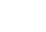

In [28]:
to_graphviz(water_flow, orientation=LeftToRight, labels=true)

We must populate with boxes to visualize anything. Each box can correspond to a submodule of the system. We must give each box a _name_, some _inputs_, and some _outputs_. The inputs and outputs follow the same vector convection as a wiring diagram. 

In [29]:
box_valve     = Box(:valve,     [:F, :λcmd], [:Fin])
box_container = Box(:container, [:Fin],      [:Fout, :wl])
box_sensor    = Box(:sensor,    [:wl],       [:wlm])
box_controller= Box(:controller,[:wlm],      [:λcmd])

Box(:controller, [:wlm], [:λcmd])

Having defined boxes representing the submodules, we must add these boxes to the wiring diagram we created before. Each time we add a box to a diagram, this box will become associated with a particular id number. While adding a box, we can store this number for future reference. The ids are assigned by the order in which boxes are added. The first box to be added has id = 1, while the third has id=3, etc. 

In [30]:
# add boxes to diagram
valve_id      = add_box!(water_flow, box_valve)
container_id  = add_box!(water_flow, box_container)
sensor_id     = add_box!(water_flow, box_sensor)
controller_id = add_box!(water_flow, box_controller)

4

If we display our system after adding the boxes, we'll notice it is incomplete. The diagram is populated, but there are no connections between the boxes.

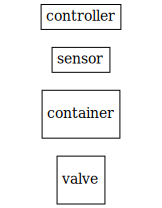

In [31]:
to_graphviz(water_flow, orientation=LeftToRight, labels=true)

We can assign connections with the id number of each of the boxes. To do so, we must consider the idea of a _port number_. This unique identifier is associated with a particular connection on a box. Given that boxes have inputs and outputs, each set has a list of port numbers.  

The port numbers work the same way as box ids. Each input or output we add to a box will have an id number based on how the variable was assigned to a box. Consider a connection between the _first output_ of the valve _Fin_ and the _first input_ of the container _Fin_. We can add this connection as follows:

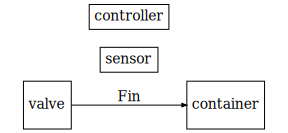

In [32]:
# add connections
add_wires!(water_flow, [
    (valve_id, 1) => (container_id, 1),
])

# View graph
to_graphviz(water_flow, orientation=LeftToRight, labels=true)

By following the same procedure, we can assign connections between other boxes inside the system:

In [33]:
# add connections
add_wires!(water_flow, [
    (container_id, 2) => (sensor_id, 1),
    (sensor_id, 1) => (controller_id, 1),
    (controller_id, 1) => (valve_id, 2),
]);

At this point, all that is left is to add connections that enter or exit the system. We can assign these connections by treating the _entire system_ as a box that has its _own set of port numbers_. These numbers are assigned by the order in which we initially added inputs and outputs to the wiring diagram.

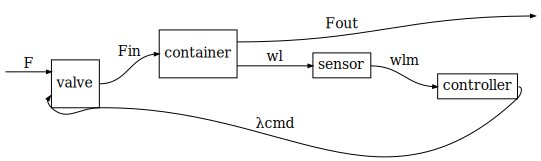

In [34]:
# add connections
add_wires!(water_flow, [
    # Net Inputs      
    (input_id(water_flow),1) => (valve_id,1),
    # Net Outputs
    (container_id,1) => (output_id(water_flow),1)
])

# Visualize system
to_graphviz(water_flow, orientation=LeftToRight, labels=true)

## Wiring diagram semantics

Having created a diagram to define the connections inside of our system, we can define the behavior of each of the boxes. This is accomplished through a dynamics function and a readout function. These functions have the following requirements: 

__Dynamics function__: This function is used to update the state of a box. It takes in four parameters as inputs:
1. __u__: The system's current state is represented by a state-space vector.
2. __x__: A vector carrying all external inputs entering the system. The index of each vector element corresponds to the port number of said element. For example, x[1] corresponds to the input variable at port_number=1.
3. __p__:Parameter array containing _all_ of the constants used by _every_ box across the system. Given this array is shared across all boxes, it is best to _uniquely_ identify a specific value through a label.
4. __t__. variable used to execute time dependant function and depends on the system question.  

The output of the dynamics function is an _updated_ state vector __u__. Each element of this vector is assigned to a state of the box. For example, if a box has 3 state variables, the readout function _must_ output a vector u=[u1,u2,u3]. 

__Readout function__: This function will generate the values that other boxes will use as their external inputs. It receives three parameters as inputs:
1. __u__: The state vector of the box.
2. __p__: The global parameter array.
3. __t__: A time variable.

The readout function _must_ output a vector with the same number of entries as output variables. Each entry is assigned to the outgoing wires of the box. For example, if the output is Y=[y1,y2] then y1 will be assigned to the wire at output_port=1, and y2 is assigned to the wire at output_port=2. 

For more information on the Dynamics and readout functions, see the documentation for [AlgebraicDynamics](https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/).

With this information in mind, we can construct the dynamics functions for each box. For clarity, we'll use the same variable names as the paper using [labeled arrays](https://juliapackages.com/p/labelledarrays). We can use them by defining labels for each of the vectors used by the functions.  

In [35]:
# Dynamics functions of each box
function dynamics_valve(u,x,p,t)
    u = @LArray u (:λ,) 
    x = @LArray x (:F, :λcmd,)
    dλ = (x.λcmd - u.λ) * 0.5
    return [ dλ ]
end

function dynamics_container(u,x,p,t)
    u = @LArray u (:wl,) 
    x = @LArray x (:Fin,)
    Fout = u.wl <= 0 ? 0 : p.Sout*sqrt( 2*p.g*u.wl )
    return [ (x.Fin - Fout - p.𝜀)/( pi*(p.D/2)^2 ) ]  
end

function dynamics_sensor(u,x,p,t)
    u = @LArray u (:wlm,)
    x = @LArray x (:wl,)
    return [ (x.wl - u.wlm)*p.ks ]
end

function dynamics_controller(u,x,p,t)
    u = @LArray u (:λcmd,)
    x = @LArray x (:wlm,)
    λt = x.wlm < p.wlmin ? 1 : 
         x.wlm > p.wlmax ? 0 : u.λcmd
    return [ (λt - u.λcmd)*p.kc ]
end

dynamics_controller (generic function with 1 method)

We can construct the readout functions the same way as the dynamics functions. Note that in all cases, __p__ values are uniquely identified through a label.

In [36]:
# Readout function of each box
function readout_valve(u, p, t)
    u = @LArray u (:λ,)
    Fin = p.F*(0.2*u.λ^2 + 0.8*u.λ)
    return return [Fin]
end

function readout_container(u, p, t) 
    u = @LArray u (:wl,)
    Fout = u.wl < 0 ? 0 : p.Sout*sqrt( 2*p.g*u.wl )
    return [Fout, u.wl]
end

readout_sensor(u, p, t) = u
readout_controller(u, p, t) = u

readout_controller (generic function with 1 method)

# Static contracts
We can now define the _contracts_ we want the boxes to satisfy. This is accomplished by constructing intervals that define a range of acceptable values. There is one such interval for each wire entering or exiting a box. 

Their interpretation is simple: if the value of a variable at a specified _wire port_ is within the assigned interval, the contract is _satisfied_. If the value is outside this range, the contract has been _violated_. 

We can create these intervals using the double period operator and functions from the [IntervalSets](https://github.com/JuliaMath/IntervalSets.jl) module. 

In [37]:
# Legend:
# F:    Input flow rate 
# Fin:  flow rate through valve
# wl:   water level in container
# wlm:  measured water level
# λcmd: commanded valve position
# λ:    valve position

# Input and output contracts for each box at each port
                                # Variables     # Units 
sensor_in = [0.2..10]           # wl            m
sensor_out = [0.2..10]          # wlm           m

controller_in = [5..6]          # wlm           m
controller_out = [0..1]         # λcmd          n/a

container_in = [0..6]           # Fin           m^3/s
container_out = [1..8, 0..8]    # Fout, wl      m^3/s , m

valve_in = [0..6, 0..1]         # F, λcmd       m^3/s, m
valve_out = [0..6]              # Fin           m^3/s

1-element Vector{ClosedInterval{Int64}}:
 0..6

In [38]:
# 1. Interface
# The contract machines are created with the following inputs:

# ContractMachine{Type}(InputContracts, NumberOfStates, OutputContracts, 
#                       DynamicsFunction, ReadoutFunction)

# 2. Creating atomic contract machines
valve_machine      = ContractMachine{Float64}(valve_in, 1, valve_out,     
                                                            dynamics_valve, 
                                                            readout_valve)

container_machine  = ContractMachine{Float64}(container_in, 1, container_out, 
                                                            dynamics_container, 
                                                            readout_container)

sensor_machine     = ContractMachine{Float64}(sensor_in, 1, sensor_out,    
                                                            dynamics_sensor, 
                                                            readout_sensor)

controller_machine = ContractMachine{Float64}(controller_in, 1, controller_out,   
                                                            dynamics_controller, 
                                                            readout_controller)

StaticContract( [5,6] × [0,1] )[Machine]

We can compose all of these machines together using the wiring diagram as a final step. It is important to remember that every box in the wiring diagram _requires_ a contract machine. 

In [39]:
# Compose system
water_system = oapply(water_flow, Dict( :valve => valve_machine, 
                                        :container => container_machine, 
                                        :sensor => sensor_machine, 
                                        :controller => controller_machine )) 

WARNING! undefined contract between container (id=2) and sensor (id=3) at wire "wl":
                    [0,8] ∩ [0.2,10.0] ≠ [0,8]
WARNING! undefined contract between sensor (id=3) and controller (id=4) at wire "wlm":
                    [0.2,10.0] ∩ [5,6] ≠ [0.2,10.0]


StaticContract( [0,6] × [1,8] )[Machine]

# Evaluate system 
Once we have composed the system, we can find out its behavior using an ODE solver, a list of parameters, and a set of initial conditions. 

In [40]:
# Initial conditions
u_init = LVector(λ = 0.0,   # valve position [0, 1]
                wl = 9.0,   # water level in container
                wlm = 9.0,  # measured water level
                λcmd = 0.0) # commanded valve position [sent by controller]

# NOTE: The container must drain faster than the input flow fills it. 
pvalve = LVector(Sout = 0.16, # Exit area of container | | m^2
                g = 9.81,     # Acceleration due to gravity | m/s^2
                D = 5.0,      # Diameter of container | m
                wlmax = 6,    # maximum water level | m
                wlmin = 5,    # minimum water level | m
                ks = 0.5,     # time constant of sensor, 1rst order
                kc = 1,       # time constant of controller, 1rst order
                𝜀 = 0.25/3600,# Evaporation rate | m^3/s
                F = 5)        # Input flow rate | m^3/s

#External inputs
x_init = [pvalve.F]

# Integration span must be large enough to see steady state behavior
tspan = (0.0, 100.0)

(0.0, 100.0)

In [41]:
# Solve Dynamics. The water level should reach the desired value
prob = ODEProblem(water_system, u_init, x_init, tspan, pvalve)
sol = solve( prob, alg_hints=[:stiff], adaptive=:false, dt=0.1 );

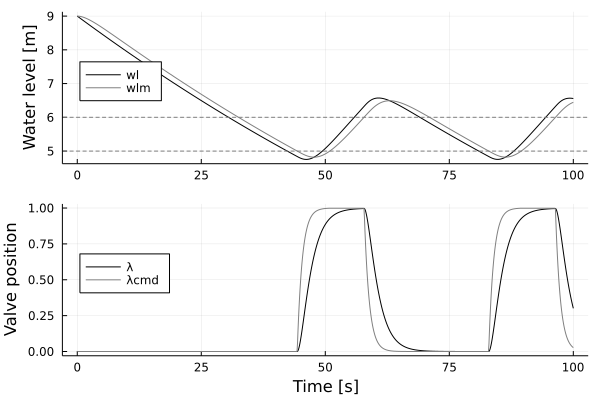

In [42]:
# Display results
# 1. Water level
p1 = plot( sol.t, [sol[:wl,:] sol[:wlm, :]], 
    linecolor=[:black :grey], legend=:left,     
    ylabel="Water level [m]", 
    label=["wl" "wlm"] )

# 1b. Target values
hline!( [pvalve.wlmax pvalve.wlmin], linestyle=:dash, label=:none, linecolor=[:grey :grey] )

# 2. Valve position
p2 = plot( sol.t, [sol[:λ,:], sol[:λcmd, :]],
    linecolor=[:black :grey], legend=:left,
    xlabel="Time [s]", ylabel="Valve position", 
    label=["λ" "λcmd"] )

# 3. Merge plots
plot(p1, p2, layout=(2,1))

In [43]:
# Save plot
savefig("img/water_flow_plot.svg")

With some results for the system's behavior, we can check whether the contracts were satisfied. We do some by using the solution of the ode solver, the combined system, and the initial inputs and parameters.

In [44]:
# Show when and where contracts were violated
    # Note: Adjust stepsize to improve accuracy of failure intervals
dict = check_contract(sol, water_system, x_init, pvalve, out_type="time")

box,input,output
directory,wire: failure interval,wire: failure interval
valve,,
controller,"wlm : 0.000000 , 32.500000wlm : 44.400000 , 50.900000wlm : 57.900000 , 71.000000wlm : 83.000000 , 89.400000wlm : 96.400000 , 100.000000",
sensor,,
container,,"wl : 0.000000 , 9.500000"


The table shows a lot of information. Here's what it means:
- The box column gives us a list of the boxes that form our system. Should any of these boxes be formed from the composition of _other_ boxes, they will be listed in a direction akin to the file directories used by computers. 
- The input column tells us which _input wires_ of a particular box failed to satisfy its contract, and it also tells us the _time interval_ during which this violation occurred. If a wire fails multiple times, it will be listed multiple times.
- The output column follows the same format as the input column. Listed are the _output wires_ that failed to meet their contracts and the time intervals this occurred. 

We can check this information by comparing the contract intervals we assigned earlier with the results from the ODE solver. For example, consider the input "wl" of the sensor box. Our contract states that it has to measure a water level between 0.1m and 0.6m. By looking at the graph, we can see that "wlm", the measured water level, is _below_ 0.1m for any before 31.25 seconds. Therefore, during this time interval, the contract we state has been _violated_. The same logic checks every contract assigned throughout the system. 